In [7]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

In [ ]:
def preprocess_design_matrix(design_matrix):

    design_matrix = design_matrix[design_matrix['sofa_score_baseline'] == 0.0]


    # design_matrix['sofa_sofa_diff2'] = design_matrix['sofa_sofa_day2'] - design_matrix['sofa_sofa_baseline']
    # design_matrix['sofa_sofa_diff3'] = design_matrix['sofa_sofa_day3'] - design_matrix['sofa_sofa_baseline']
    # design_matrix['sofa_sofa_diff1'] = design_matrix['sofa_sofa_day1'] - design_matrix['sofa_sofa_baseline']

    design_matrix['max_sofa_increase'] = np.max(
        design_matrix[
            [
                'sofa_score_increase_day1', 
                'sofa_score_increase_day2', 
                'sofa_score_increase_day3'
            ]
        ], 
        axis=1
    )

    # design_matrix = design_matrix[
    #     (design_matrix['max_sofa_increase'] < 1.0) |
    #     (design_matrix['max_sofa_increase'] > 3.0)
    # ].copy()


    design_matrix['group'] = np.where(
        design_matrix['max_sofa_increase'] > 1, 2, 1
    )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [9]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]

    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix       


# Model Training

In [10]:
ms_data = pd.read_csv(
    "../0_data/proteins_train_filtered.tsv"
    , sep="\t"
)

In [11]:
design_matrix_otrain = pd.read_csv(
    "../0_data/design_matrix_train.tsv",
    sep='\t'
)

In [12]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

/tmp/ipykernel_1036230/4080061297.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix['max_sofa_increase'] = np.max(


<Axes: xlabel='max_sofa_increase', ylabel='Count'>

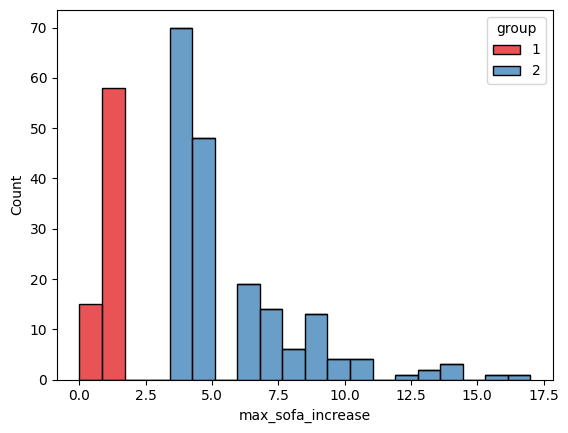

In [13]:
sns.histplot(
    design_matrix_train,
    x="max_sofa_increase",
    hue="group",
    palette="Set1",
    multiple="stack",
    bins=20
)

In [14]:
design_matrix_train['group'].value_counts()

group
2    186
1     73
Name: count, dtype: int64

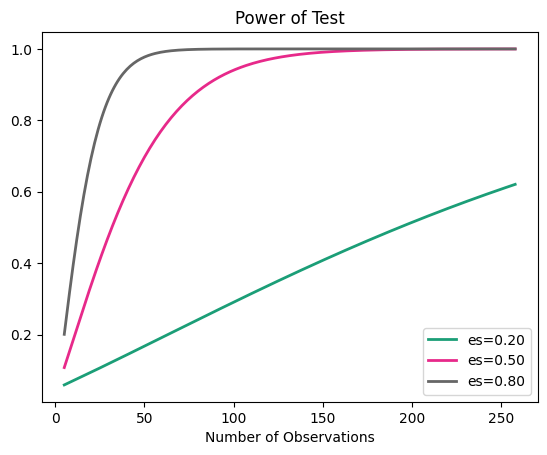

In [15]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

# parameters for power analysis
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, design_matrix_train.shape[0]))


analysis = TTestIndPower()

analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [16]:
quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [17]:
quant_matrix_train = quant_matrix_train.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [18]:
quant_matrix_train.write("de_results/sofa_de_proteins.tsv")

In [19]:
quant_matrix_de = quant_matrix_train.to_df()

<Axes: xlabel='Log2FoldChange2-1', ylabel='-Log10CorrectedPValue2-1'>

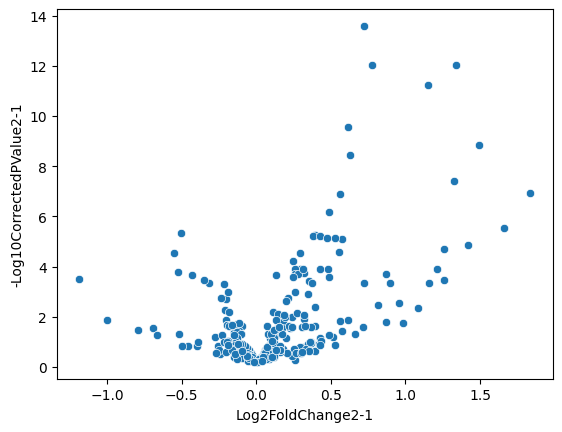

In [20]:
sns.scatterplot(
    data=quant_matrix_de,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1"
)

In [21]:
qm_filtered = (
    
    QuantMatrix(
        quantification_file=quant_matrix_de,
        design_matrix_file=design_matrix_train
    )
    
)

In [22]:
training_data, y = qm_filtered.to_ml(feature_column="ProteinLabel")

In [23]:
protein_columns = training_data.columns.to_list()

In [24]:
len(protein_columns)

287

In [25]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

X = training_data.copy()

protein_scaler = StandardScaler()

X[protein_columns] = protein_scaler.fit_transform(X[protein_columns])

X = X.copy()

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    random_state=42,
    #penalty="l1",
    class_weight="balanced",
    #C=0.1,
    #solver="liblinear",
    max_iter=1000
)

# protein_clf = BaggingClassifier(
#     estimator=protein_clf,
#     random_state=42
# )

In [27]:
from cleanlab.filter import find_label_issues
from sklearn.model_selection import cross_val_predict

pred_probs = cross_val_predict(protein_clf, X, y.values.ravel(), cv=3, method="predict_proba")

label_issues = find_label_issues(
    labels=y.values.ravel(),
    pred_probs=pred_probs,
    return_indices_ranked_by='self_confidence'  # Ranks by likelihood of being mislabeled
)

/srv/data1/home/aaron/envs/miniconda3/envs/revisionenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
mask = np.ones(len(y.values.ravel()), dtype=bool)

mask[label_issues] = False

In [29]:
X = X.iloc[mask, :].copy()
y = y.iloc[mask, :].copy()

In [30]:
y['label'].value_counts()

label
1    156
0     49
Name: count, dtype: int64

In [31]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight


class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y.values.ravel()),
    y=y.values.ravel()
)

class_weight = dict(zip(np.unique(y.values.ravel()), class_weight))

class_weight

{0: 2.0918367346938775, 1: 0.657051282051282}

In [32]:
len(protein_columns)

287

In [33]:
from mrmr import mrmr_classif
selected_proteins = mrmr_classif(X=X[protein_columns], y=y.values.ravel(), K=50)

100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


In [34]:
selected_proteins

['CYTC_HUMAN',
 'ITB3_HUMAN',
 'IBP3_HUMAN',
 'IBP2_HUMAN',
 'VWF_HUMAN',
 'CATB_HUMAN',
 'TIMP1_HUMAN',
 'B2MG_HUMAN',
 'PSPB_HUMAN',
 'ALS_HUMAN',
 'H4_HUMAN',
 'VCAM1_HUMAN',
 'VSIG4_HUMAN',
 'CALR_HUMAN',
 'ECM1_HUMAN',
 'FETUB_HUMAN',
 'LYSC_HUMAN',
 'ITIH3_HUMAN',
 'AACT_HUMAN',
 'FBLN3_HUMAN',
 'LCAT_HUMAN',
 'SODC_HUMAN',
 'COIA1_HUMAN',
 'CFAD_HUMAN',
 'F13B_HUMAN',
 'K22E_HUMAN',
 'RS27A_HUMAN',
 'CNDP1_HUMAN',
 'CO7_HUMAN',
 'FETUA_HUMAN',
 'IBP7_HUMAN',
 'ICAM1_HUMAN',
 'CMGA_HUMAN',
 'APOL1_HUMAN',
 'RNAS1_HUMAN',
 'MRC1_HUMAN',
 'C163A_HUMAN',
 'ACTN1_HUMAN',
 'A1AG1_HUMAN',
 'CBG_HUMAN',
 'CD14_HUMAN',
 'A1AT_HUMAN',
 'RNAS4_HUMAN',
 'LDHA_HUMAN',
 'THBG_HUMAN',
 'LDHB_HUMAN',
 'TETN_HUMAN',
 'PLTP_HUMAN',
 'SEPP1_HUMAN',
 'FBLN5_HUMAN']

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [36]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3)
eval_result = cross_validate(
    protein_clf, X[selected_proteins], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.9294871794871794, 0.936378989051945, 0.8974140380789998, 0.8624151583710407)

In [37]:
from dpks.interpretation import BootstrapInterpreter

protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_proteins,
    downsample_background=True,
    shuffle_iterations=100
)

In [38]:
protein_interpreter.fit(X[selected_proteins].values, y.values.ravel(), protein_clf)

In [39]:
protein_importances = protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [40]:
protein_importances.head(20)

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
37,ACTN1_HUMAN,0.264681,22.0,0.320720,15.0,0.240028,24.0,0.631225,5.0,1.000000,...,0.656578,10.0,0.331048,15.0,0.686350,0.745053,0.287964,9.12,4.0,10.712289
15,FETUB_HUMAN,0.685784,3.0,0.353112,14.0,0.403736,10.0,0.663513,4.0,0.578091,...,0.876517,3.0,0.624911,2.0,0.597282,0.616384,0.229398,10.00,8.0,8.399134
44,THBG_HUMAN,0.315626,16.0,0.849333,3.0,0.451431,6.0,0.711771,3.0,0.341065,...,0.545209,14.0,0.540121,6.0,0.583658,0.583800,0.229026,10.78,7.0,9.734433
1,ITB3_HUMAN,0.346791,11.0,0.431499,12.0,0.639634,3.0,0.501951,10.0,0.417512,...,0.906751,2.0,0.531801,7.0,0.580440,0.558433,0.258030,11.68,9.0,10.411610
13,CALR_HUMAN,1.000000,1.0,0.228609,25.0,0.371839,13.0,0.304025,21.0,0.091446,...,0.310298,26.0,0.285246,18.0,0.569264,0.565993,0.278651,12.22,8.0,11.274876
14,ECM1_HUMAN,0.395242,8.0,0.292471,19.0,0.500608,5.0,0.623980,6.0,0.318311,...,0.639724,12.0,0.210704,26.0,0.516345,0.493032,0.252435,14.28,12.0,11.700885
11,VCAM1_HUMAN,0.269684,21.0,0.914831,2.0,0.404326,9.0,1.000000,1.0,0.464201,...,0.649260,11.0,0.350043,13.0,0.488293,0.475744,0.255867,15.83,11.5,12.605959
3,IBP2_HUMAN,0.469408,6.0,0.545162,9.0,0.376571,11.0,0.236268,25.0,0.433163,...,0.706518,7.0,0.189983,28.0,0.484946,0.467898,0.238917,15.14,11.5,11.339588
28,CO7_HUMAN,0.263759,23.0,0.309385,16.0,0.145450,33.0,0.195897,31.0,0.321968,...,0.264088,33.0,0.240058,22.0,0.480042,0.477469,0.281689,16.82,11.5,14.095905
21,SODC_HUMAN,0.092792,40.0,0.517813,11.0,0.371390,14.0,0.890089,2.0,0.473735,...,0.340951,23.0,0.068200,42.0,0.471500,0.443510,0.300751,17.92,13.0,14.259981


In [41]:
selected_proteins = protein_importances.head(10)['feature'].to_list()

In [42]:
from dpks.interpretation import Classifier


protein_clf = Classifier(protein_clf)

In [43]:
selected_features = selected_proteins[:10]

In [44]:
for feature in selected_features:

    print(feature)

ACTN1_HUMAN
FETUB_HUMAN
THBG_HUMAN
ITB3_HUMAN
CALR_HUMAN
ECM1_HUMAN
VCAM1_HUMAN
IBP2_HUMAN
CO7_HUMAN
SODC_HUMAN


In [45]:
protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [46]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[selected_features], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.9358974358974358,
 0.9733279978658129,
 0.9317277635691958,
 0.9268947963800905)

In [47]:
cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[protein_columns], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.9615384615384616,
 0.9618736383442266,
 0.9414606422279057,
 0.9201074660633485)

In [48]:
from dpks.interpretation import BootstrapInterpreter

final_protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_features,
    downsample_background=True,
    shuffle_iterations=100
)

In [49]:
final_protein_interpreter.fit(X[selected_features].values, y.values.ravel(), protein_clf)

In [50]:
final_protein_importances = final_protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [51]:
final_protein_importances

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
6,VCAM1_HUMAN,0.905282,2.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,...,1.000000,1.0,0.869950,2.0,0.873518,0.977758,0.166232,2.23,2.0,1.674859
1,FETUB_HUMAN,1.000000,1.0,0.920030,2.0,0.688448,3.0,0.710906,2.0,0.779875,...,0.901995,4.0,1.000000,1.0,0.829968,0.895477,0.170222,2.49,2.0,1.487286
5,ECM1_HUMAN,0.466501,6.0,0.440528,6.0,0.595217,5.0,0.591827,4.0,0.489555,...,0.987732,2.0,0.561464,3.0,0.623546,0.601323,0.202017,4.35,4.0,1.976503
7,IBP2_HUMAN,0.570673,4.0,0.466859,5.0,0.750402,2.0,0.317093,7.0,0.549850,...,0.914844,3.0,0.483268,4.0,0.578988,0.544312,0.235357,5.17,5.0,2.663085
9,SODC_HUMAN,0.468122,5.0,0.614852,3.0,0.643932,4.0,0.673712,3.0,0.606669,...,0.436768,6.0,0.417596,6.0,0.547078,0.565154,0.212911,5.41,5.0,2.566667
8,CO7_HUMAN,0.344745,7.0,0.382557,9.0,0.325152,9.0,0.377535,5.0,0.546671,...,0.153059,10.0,0.090243,10.0,0.503446,0.533470,0.230724,6.02,6.0,2.498404
3,ITB3_HUMAN,0.298383,9.0,0.388192,8.0,0.490095,8.0,0.304956,8.0,0.415893,...,0.397993,7.0,0.367281,8.0,0.447870,0.421329,0.176604,6.85,7.0,2.056647
4,CALR_HUMAN,0.735357,3.0,0.404368,7.0,0.504838,6.0,0.338026,6.0,0.075827,...,0.593073,5.0,0.399026,7.0,0.418651,0.408739,0.212203,7.21,8.0,2.458935
2,THBG_HUMAN,0.257935,10.0,0.533822,4.0,0.504416,7.0,0.280597,9.0,0.284046,...,0.290789,9.0,0.329792,9.0,0.389414,0.389417,0.147149,7.68,8.0,1.693004
0,ACTN1_HUMAN,0.305393,8.0,0.228910,10.0,0.149365,10.0,0.276190,10.0,0.589100,...,0.351578,8.0,0.421410,5.0,0.379456,0.340632,0.191752,7.59,8.0,2.378757


In [52]:
final_protein_importances.to_csv(
    "feature_importances/sofa_protein_importances.tsv",
    sep="\t",
    index=False
)

# Model Testing

In [53]:
ms_data_test = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [54]:
design_matrix_test = preprocess_design_matrix(design_matrix_test)

quant_matrix_test = preprocess_data(ms_data_test, design_matrix=design_matrix_test)

In [55]:
quant_matrix_test_df = quant_matrix_test.to_df()
#quant_matrix_test_df = quant_matrix_test_df[quant_matrix_test_df['ProteinLabel'].isin(selected_features)]

In [56]:
qm_filtered_test = (
    
    QuantMatrix(
        quantification_file=quant_matrix_test_df,
        design_matrix_file=design_matrix_test
    )
    
)

In [57]:
testing_data, y_test = qm_filtered_test.to_ml(feature_column="ProteinLabel")

In [58]:
X_test = testing_data.copy()

X_test[protein_scaler.feature_names_in_] = protein_scaler.transform(X_test[protein_scaler.feature_names_in_])

X_test = X_test.copy()

In [59]:
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
svc = SVC(random_state=42)
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
mlp = MLPClassifier(random_state=42)


lr_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

# lr_clf = BaggingClassifier(
#     estimator=lr_clf,
#     random_state=42
# )

xgb_clf = XGBClassifier(
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    learning_rate=0.01,
    n_estimators=1000,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_jobs=1
)


In [60]:
lr_clf.fit(X[selected_features], y.values.ravel(), )
xgb_clf.fit(X[selected_features], y.values.ravel(), )
decision_tree.fit(X[selected_features], y.values.ravel(), ) 
random_forest.fit(X[selected_features], y.values.ravel(), )
svc.fit(X[selected_features], y.values.ravel(), )
knn.fit(X[selected_features], y.values.ravel()) 
naive_bayes.fit(X[selected_features], y.values.ravel(), ) 
mlp.fit(X[selected_features], y.values.ravel())

MLPClassifier(random_state=42)

In [61]:
from sklearn.metrics import f1_score

lr_predictions = lr_clf.predict(X_test[selected_features])
lr_ba = f1_score(y_test.values.ravel(), lr_predictions)

xgb_predictions = xgb_clf.predict(X_test[selected_features])
xgb_ba = f1_score(y_test.values.ravel(), xgb_predictions)

decision_tree_predictions = decision_tree.predict(X_test[selected_features])
decision_tree_ba = f1_score(y_test.values.ravel(), decision_tree_predictions)

rf_predictions = random_forest.predict(X_test[selected_features])
rf_ba = f1_score(y_test.values.ravel(), rf_predictions)

svc_predictions = svc.predict(X_test[selected_features])
svc_ba = f1_score(y_test.values.ravel(), svc_predictions)

knn_predictions = knn.predict(X_test[selected_features])
knn_ba = f1_score(y_test.values.ravel(), knn_predictions)

nb_predictions = naive_bayes.predict(X_test[selected_features])
nb_ba = f1_score(y_test.values.ravel(), nb_predictions)

mlp_predictions = mlp.predict(X_test[selected_features])
mlp_ba = f1_score(y_test.values.ravel(), mlp_predictions)

In [62]:
lr_ba, xgb_ba, decision_tree_ba, rf_ba, svc_ba, knn_ba, nb_ba, mlp_ba

(0.864321608040201,
 0.8651162790697674,
 0.8376470588235294,
 0.8738738738738738,
 0.8726415094339622,
 0.8624708624708625,
 0.8660287081339713,
 0.8695652173913043)

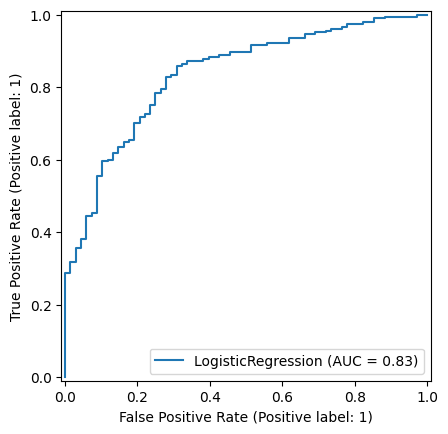

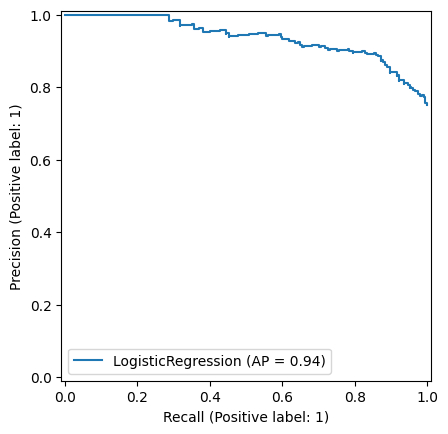

In [63]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)


PrecisionRecallDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)





In [64]:
from sklearn.metrics import roc_curve

y_probs = lr_clf.predict_proba(X_test[selected_features])[:, 1]

# Compute ROC curve metrics
fpr, tpr, thresholds = roc_curve( y_test.values.ravel(), y_probs)

# Create a DataFrame to store the metrics
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})


In [65]:
roc_df.to_csv(
    "roc/sofa.tsv",
    sep="\t"
)

# Probability Prediction

In [66]:
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

design_matrix_test['sample'] = design_matrix_test['injection']
design_matrix_test['group'] = 1

quant_matrix_predict = QuantMatrix(
    quantification_file=ms_data_test,
    design_matrix_file=design_matrix_test,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
).impute(method="uniform_percentile", percentile=0.01)

predict_data, y_test_alll = quant_matrix_predict.to_ml(feature_column="ProteinLabel")

In [67]:
predict_data = predict_data[protein_columns].copy()

In [68]:
predict_data[protein_columns] = protein_scaler.transform(predict_data[protein_columns])

In [69]:
predict_data['sofa_probability'] = lr_clf.predict_proba(predict_data[selected_features])[:, 1]

In [70]:
design_matrix_test = design_matrix_test.set_index("injection").join(
    predict_data['sofa_probability']
).reset_index()

In [71]:
predict_data[['sofa_probability']].to_csv(
    "predictions_test/sofa.tsv",
    sep="\t"
)

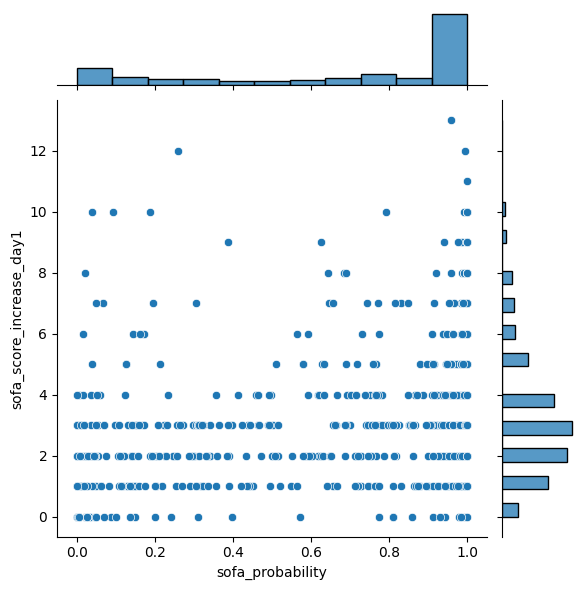

In [72]:
sns.jointplot(
    data=design_matrix_test,
    x="sofa_probability",
    y="sofa_score_increase_day1",
    #hue="sofa_score_increase_day1"
)

In [73]:
design_matrix_test['general_sofa'] = np.where(
    design_matrix_test['sofa_score_increase_day1'] > 3, 1, 0
)

<Axes: xlabel='sofa_probability', ylabel='Count'>

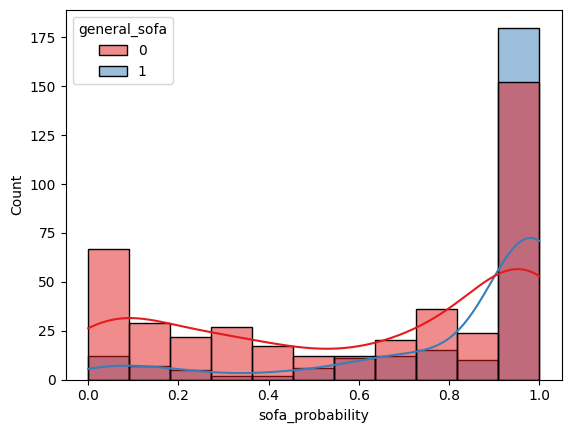

In [74]:
sns.histplot(
    data=design_matrix_test,
    x="sofa_probability",
    hue="general_sofa",
    palette="Set1", 
    kde=True,
    #multiple="stack"
)

In [75]:
ms_data_val = pd.read_csv(
    "../0_data/proteins_val_filtered.tsv"
    , sep="\t"
)

design_matrix_val = pd.read_csv(
    "../0_data/design_matrix_validation.tsv",
    sep='\t'
)

design_matrix_val['sample'] = design_matrix_val['injection']
design_matrix_val['group'] = 1

quant_matrix_val = QuantMatrix(
    quantification_file=ms_data_val,
    design_matrix_file=design_matrix_val,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

val_data, y_val = quant_matrix_val.to_ml(feature_column="ProteinLabel")

In [76]:
val_data = val_data[protein_columns].copy()

In [77]:
val_data[protein_columns] = protein_scaler.transform(val_data[protein_columns])

In [78]:
val_data['sofa_probability'] = lr_clf.predict_proba(val_data[selected_features])[:, 1]

In [79]:
design_matrix_val = design_matrix_val.set_index("injection").join(
    val_data['sofa_probability']
).reset_index()

In [80]:
val_data[['sofa_probability']].to_csv(
    "predictions_val/sofa.tsv",
    sep="\t"
)

<Axes: xlabel='sofa_probability', ylabel='Count'>

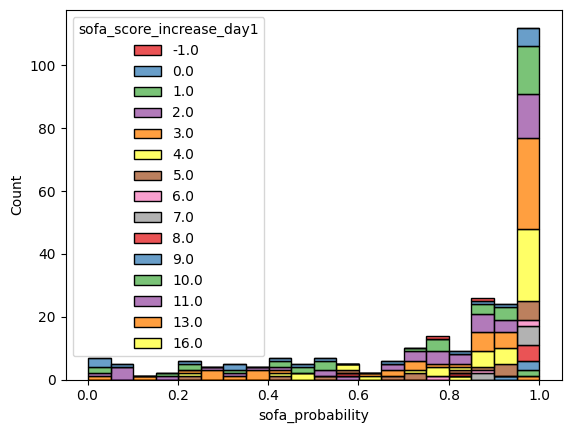

In [81]:
sns.histplot(
    data=design_matrix_val,
    x="sofa_probability",
    hue="sofa_score_increase_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [82]:
ms_data_hero = pd.read_csv(
    "../0_data/proteins_hero_filtered.tsv"
    , sep="\t"
)

design_matrix_hero = pd.read_csv(
    "../0_data/design_matrix_hero.tsv",
    sep='\t'
)

design_matrix_hero['sample'] = design_matrix_hero['injection']
design_matrix_hero['group'] = 1

quant_matrix_hero = QuantMatrix(
    quantification_file=ms_data_hero,
    design_matrix_file=design_matrix_hero,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

hero_data, y_hero = quant_matrix_hero.to_ml(feature_column="ProteinLabel")

In [83]:
hero_data = hero_data[protein_columns].copy()

In [84]:
hero_data[protein_columns] = protein_scaler.transform(hero_data[protein_columns])

In [85]:
hero_data['sofa_probability'] = lr_clf.predict_proba(hero_data[selected_features])[:, 1]

In [86]:
design_matrix_hero = design_matrix_hero.set_index("injection").join(
    hero_data['sofa_probability']
).reset_index()

In [87]:
hero_data[['sofa_probability']].to_csv(
    "predictions_external/sofa.tsv",
    sep="\t"
)

<Axes: xlabel='sofa_probability', ylabel='Count'>

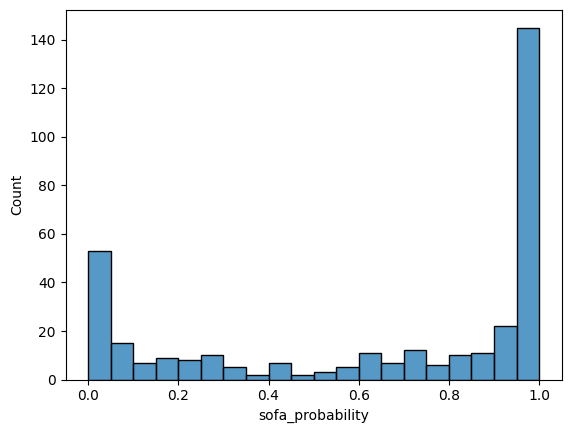

In [88]:
sns.histplot(
    data=hero_data,
    x="sofa_probability",
    #hue="sofa_sofa_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [89]:
from joblib import dump


with open("models/sofa_protein_model.pkl", "wb") as f:

    dump(lr_clf, f)

with open("models/sofa_protein_scaler.pkl", "wb") as f:

    dump(protein_scaler, f)
